In [1]:
import csv
import gzip
import random
import sqlite3
import sys
import time
import json
import numpy as np
import colorspacious
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, SeparableConv1D, Activation
import tensorflow as tf
import sklearn.utils
import matplotlib.pyplot as plt
import scipy.interpolate

In [2]:
# Force CPU operation for deterministic and reproducible results
# Disable parallelism per https://github.com/NVIDIA/framework-determinism/blob/28091e4fb1483685fc78b7ab844a5ae6ddf55a14/README.md#cpu
tf.config.set_visible_devices([], "GPU")
tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(1)

In [3]:
# Needed for deterministic results
SEED = 567687
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [4]:
COLOR_FILE = {
    6: "../set-generation/colors_mcd20.0_mld5.0_nc6_cvd100_minj40_maxj80_ns10000_f.txt",
    8: "../set-generation/colors_mcd18.0_mld4.2_nc8_cvd100_minj40_maxj82_ns10000_f.txt",
    10: "../set-generation/colors_mcd16.0_mld3.6_nc10_cvd100_minj40_maxj84_ns10000_f.txt",
}
ALL_NUM_COLORS = COLOR_FILE.keys()
DB_FILE = "../survey-results/results.db"

In [5]:
ENSEMBLE_COUNT = 100

## Color conversion and sorting functions

Data are all stored as 8-bit RGB values and need to be converted to CAM02-UCS.

We also need to be able to sort along the three CAM02-UCS axes.

In [6]:
def to_jab(color):
    """
    Convert hex color code (without `#`) to CAM02-UCS.
    """
    rgb = [(int(i[:2], 16), int(i[2:4], 16), int(i[4:], 16)) for i in color]
    jab = [colorspacious.cspace_convert(i, "sRGB255", "CAM02-UCS") for i in rgb]
    return np.array(jab)


def sort_colors_by_j(colors):
    """
    Sorts colors by CAM02-UCS J axis.
    """
    return colors[np.lexsort(colors[:, ::-1].T, 0)]


def sort_colors_by_a(colors):
    """
    Sorts colors by CAM02-UCS a axis.
    """
    return colors[np.argsort(colors[:, ::-1].T[1])]


def sort_colors_by_b(colors):
    """
    Sorts colors by CAM02-UCS b axis.
    """
    return colors[np.argsort(colors[:, ::-1].T[2])]

## Data loading

Survey data are loaded from a SQLite database, and the complete set of color sets is loaded from a text file. The 8-bit RGB values are converted to CAM02-UCS and sorted along the three CAM02-UCS axes.

In [7]:
# Load survey data
data_sorted_by_j = {}
data_sorted_by_a = {}
data_sorted_by_b = {}
targets = {}
min_count = 1e10

conn = sqlite3.connect(DB_FILE)
c = conn.cursor()

for num_colors in ALL_NUM_COLORS:
    count = 0
    data_sorted_by_j[num_colors] = []
    data_sorted_by_a[num_colors] = []
    data_sorted_by_b[num_colors] = []
    targets[num_colors] = []
    for row in c.execute(
        f"SELECT c1, c2, sp FROM picks WHERE length(c1) = {num_colors * 7 - 1}"
    ):
        count += 1
        # Convert to Jab [CAM02-UCS based]
        jab1 = to_jab(row[0].split(","))
        jab2 = to_jab(row[1].split(","))
        # Add to data arrays
        data_sorted_by_j[num_colors].append(
            np.array((sort_colors_by_j(jab1), sort_colors_by_j(jab2))).flatten()
        )
        data_sorted_by_a[num_colors].append(
            np.array((sort_colors_by_a(jab1), sort_colors_by_a(jab2))).flatten()
        )
        data_sorted_by_b[num_colors].append(
            np.array((sort_colors_by_b(jab1), sort_colors_by_b(jab2))).flatten()
        )
        targets[num_colors].append(row[2] - 1)
    data_sorted_by_j[num_colors] = np.array(data_sorted_by_j[num_colors])
    data_sorted_by_a[num_colors] = np.array(data_sorted_by_a[num_colors])
    data_sorted_by_b[num_colors] = np.array(data_sorted_by_b[num_colors])
    targets[num_colors] = np.array(targets[num_colors])
    min_count = min(min_count, count)
    print(num_colors, count)

conn.close()

6 10347
8 10371
10 1705


In [8]:
# Load color data
colors_rgb = {}
colors_sorted_by_j = {}
colors_sorted_by_a = {}
colors_sorted_by_b = {}
for num_colors in ALL_NUM_COLORS:
    with open(COLOR_FILE[num_colors]) as csv_file:
        # Skip header rows
        csv_file.readline()
        csv_file.readline()
        csv_file.readline()
        csv_reader = csv.reader(csv_file, delimiter=" ")
        colors_rgb[num_colors] = np.array(
            [[i.strip() for i in row] for row in csv_reader]
        )
        colors_sorted_by_j[num_colors] = []
        colors_sorted_by_a[num_colors] = []
        colors_sorted_by_b[num_colors] = []
        for i in colors_rgb[num_colors]:
            jab = to_jab(i)
            colors_sorted_by_j[num_colors].append(sort_colors_by_j(jab).flatten())
            colors_sorted_by_a[num_colors].append(sort_colors_by_a(jab).flatten())
            colors_sorted_by_b[num_colors].append(sort_colors_by_b(jab).flatten())
        colors_sorted_by_j[num_colors] = np.array(colors_sorted_by_j[num_colors])
        colors_sorted_by_a[num_colors] = np.array(colors_sorted_by_a[num_colors])
        colors_sorted_by_b[num_colors] = np.array(colors_sorted_by_b[num_colors])

In [9]:
def construct_network(num_colors):
    #
    # Construct network
    #
    conv_size = 5

    layer1j = Dense(units=5, activation="elu", name="l1j")
    layer2j = Dense(units=5, activation="elu", name="l2j")
    layer1a = Dense(units=5, activation="elu", name="l1a")
    layer2a = Dense(units=5, activation="elu", name="l2a")
    layer1b = Dense(units=5, activation="elu", name="l1b")
    layer2b = Dense(units=5, activation="elu", name="l2b")

    layer3j = SeparableConv1D(
        5, conv_size, padding="same", activation="elu", name="l3j"
    )
    layer4j = SeparableConv1D(
        3, conv_size, padding="same", activation="elu", name="l4j"
    )
    layer5j = SeparableConv1D(
        1, conv_size, padding="same", activation="elu", name="l5j"
    )
    layer3a = SeparableConv1D(
        5, conv_size, padding="same", activation="elu", name="l3a"
    )
    layer4a = SeparableConv1D(
        3, conv_size, padding="same", activation="elu", name="l4a"
    )
    layer5a = SeparableConv1D(
        1, conv_size, padding="same", activation="elu", name="l5a"
    )
    layer3b = SeparableConv1D(
        5, conv_size, padding="same", activation="elu", name="l3b"
    )
    layer4b = SeparableConv1D(
        3, conv_size, padding="same", activation="elu", name="l4b"
    )
    layer5b = SeparableConv1D(
        1, conv_size, padding="same", activation="elu", name="l5b"
    )

    # Create network
    input_a = [
        Input(shape=(3 * num_colors,)),
        Input(shape=(3 * num_colors,)),
        Input(shape=(3 * num_colors,)),
    ]
    inputs_a_j = [input_a[0][:, i * 3 : (i + 1) * 3] for i in range(num_colors)]
    inputs_a_a = [input_a[1][:, i * 3 : (i + 1) * 3] for i in range(num_colors)]
    inputs_a_b = [input_a[2][:, i * 3 : (i + 1) * 3] for i in range(num_colors)]

    # Share layers between colors
    x_a_j = [layer1j(i / 100) for i in inputs_a_j]
    x_a_a = [layer1a(i / 100) for i in inputs_a_a]
    x_a_b = [layer1b(i / 100) for i in inputs_a_b]

    x_a_j = [layer2j(i) for i in x_a_j]
    x_a_a = [layer2a(i) for i in x_a_a]
    x_a_b = [layer2b(i) for i in x_a_b]

    # Combine colors into sets
    x_a_j = tf.keras.layers.concatenate(
        [tf.keras.backend.expand_dims(i, 1) for i in x_a_j], axis=1
    )
    x_a_a = tf.keras.layers.concatenate(
        [tf.keras.backend.expand_dims(i, 1) for i in x_a_a], axis=1
    )
    x_a_b = tf.keras.layers.concatenate(
        [tf.keras.backend.expand_dims(i, 1) for i in x_a_b], axis=1
    )

    # Share layers between color sets
    x_a_j = layer3j(x_a_j)
    x_a_a = layer3a(x_a_a)
    x_a_b = layer3b(x_a_b)

    x_a_j = layer4j(x_a_j)
    x_a_a = layer4a(x_a_a)
    x_a_b = layer4b(x_a_b)

    x_a_j = layer5j(x_a_j)
    x_a_a = layer5a(x_a_a)
    x_a_b = layer5b(x_a_b)

    # Average outputs
    x_a_j = tf.math.reduce_mean(x_a_j, axis=1)
    x_a_a = tf.math.reduce_mean(x_a_a, axis=1)
    x_a_b = tf.math.reduce_mean(x_a_b, axis=1)

    # Final non-linear activation
    layer_nm1 = Activation("sigmoid", name=f"score{num_colors}")
    x_a_j = layer_nm1(x_a_j)
    x_a_a = layer_nm1(x_a_a)
    x_a_b = layer_nm1(x_a_b)

    # For evaluation
    return Model(
        inputs=input_a, outputs=tf.math.reduce_mean([x_a_j, x_a_a, x_a_b], axis=0)
    )

In [10]:
scoring_model = {nc: construct_network(nc) for nc in ALL_NUM_COLORS}

## Evaluate model accuracy

Scores are compared to calculate model accuracy. All data are used (no train / test split).

As the ten-color data were not used during design, hyperparameter tuning, or training, they serve as a validation set. These data were only evaluated after the model was finalized.

In [11]:
survey_scores_a = {nc: [] for nc in ALL_NUM_COLORS}
survey_scores_b = {nc: [] for nc in ALL_NUM_COLORS}
for nc in ALL_NUM_COLORS:
    for i in range(ENSEMBLE_COUNT):
        with gzip.open(f"weights/set_model_weights_{i:03d}.h5.gz", "rb") as infile:
            infile.endswith = lambda x: x == ".h5"  # Monkey-patch for format detection
            scoring_model[nc].load_weights(infile, by_name=True)
        survey_scores_a[nc].append(
            scoring_model[nc]
            .predict(
                [
                    data_sorted_by_j[nc][:, : nc * 3],
                    data_sorted_by_a[nc][:, : nc * 3],
                    data_sorted_by_b[nc][:, : nc * 3],
                ]
            )
            .flatten()
        )
        survey_scores_b[nc].append(
            scoring_model[nc]
            .predict(
                [
                    data_sorted_by_j[nc][:, nc * 3 :],
                    data_sorted_by_a[nc][:, nc * 3 :],
                    data_sorted_by_b[nc][:, nc * 3 :],
                ]
            )
            .flatten()
        )
    survey_scores_a[nc] = np.array(survey_scores_a[nc])
    survey_scores_b[nc] = np.array(survey_scores_b[nc])

In [12]:
for nc in ALL_NUM_COLORS:
    acc = np.mean((survey_scores_a[nc] > survey_scores_b[nc]) ^ targets[nc])
    print(f"accuracy {nc:2d}: {acc:.5f}")

accuracy  6: 0.58246
accuracy  8: 0.57541
accuracy 10: 0.57470


## Predict scores for full set of color sets

A score is predicted for each color set in the full set of color sets. Furthermore, the variability within the ensemble is also evaluated.

In [13]:
# Score color sets
scores = {nc: [] for nc in ALL_NUM_COLORS}
for nc in ALL_NUM_COLORS:
    for i in range(ENSEMBLE_COUNT):
        with gzip.open(f"weights/set_model_weights_{i:03d}.h5.gz", "rb") as infile:
            infile.endswith = lambda x: x == ".h5"  # Monkey-patch for format detection
            scoring_model[nc].load_weights(infile, by_name=True)
        scores[nc].append(
            scoring_model[nc]
            .predict(
                [colors_sorted_by_j[nc], colors_sorted_by_a[nc], colors_sorted_by_b[nc]]
            )
            .flatten()
        )
    scores[nc] = np.array(scores[nc])

In [14]:
set_scores = {}
for nc in ALL_NUM_COLORS:
    bootstrap = np.array(
        [np.mean(sklearn.utils.resample(scores[nc]), axis=0) for _ in range(1000)]
    )
    set_scores[f"mean{nc:02d}"] = scores[nc].mean(axis=0)
    set_scores[f"error{nc:02d}"] = bootstrap.std(axis=0)

In [15]:
tallies6 = scores[6].mean(axis=0)
print(6)
print("min", np.min(tallies6))
print("max", np.max(tallies6))
print("idx min", np.where(tallies6 == np.min(tallies6)))
print("idx max", np.where(tallies6 == np.max(tallies6)))
print("min", np.sort(tallies6)[:10])
print("max", np.sort(tallies6)[-10:])

6
min 0.28511593
max 0.9597851
idx min (array([637]),)
idx max (array([6278]),)
min [0.28511593 0.2876678  0.288031   0.28808674 0.28901303 0.28941134
 0.2898585  0.28987205 0.29022872 0.2911424 ]
max [0.95077294 0.9514538  0.9514684  0.9524615  0.9537752  0.9539676
 0.95442146 0.9556384  0.95655626 0.9597851 ]


In [16]:
tallies8 = scores[8].mean(axis=0)
print(8)
print("min", np.min(tallies8))
print("max", np.max(tallies8))
print("idx min", np.where(tallies8 == np.min(tallies8)))
print("idx max", np.where(tallies8 == np.max(tallies8)))
print("min", np.sort(tallies8)[:10])
print("max", np.sort(tallies8)[-10:])

8
min 0.28345084
max 0.9542912
idx min (array([5581]),)
idx max (array([2047]),)
min [0.28345084 0.28475443 0.28511116 0.2862344  0.2864122  0.28844368
 0.2889732  0.28902584 0.28916854 0.28964671]
max [0.93248504 0.9340793  0.93454903 0.935691   0.9413675  0.9422928
 0.94373405 0.9456831  0.9507198  0.9542912 ]


In [17]:
tallies10 = scores[10].mean(axis=0)
print(10)
print("min", np.min(tallies10))
print("max", np.max(tallies10))
print("idx min", np.where(tallies10 == np.min(tallies10)))
print("idx max", np.where(tallies10 == np.max(tallies10)))
print("min", np.sort(tallies10)[:10])
print("max", np.sort(tallies10)[-10:])

10
min 0.28958187
max 0.93407404
idx min (array([8713]),)
idx max (array([498]),)
min [0.28958187 0.2897035  0.2930465  0.2939599  0.29542553 0.2959087
 0.2960895  0.29644307 0.2972674  0.2973213 ]
max [0.9108968  0.9143784  0.9145386  0.9161721  0.9163575  0.9163971
 0.91915846 0.9204955  0.9211796  0.93407404]


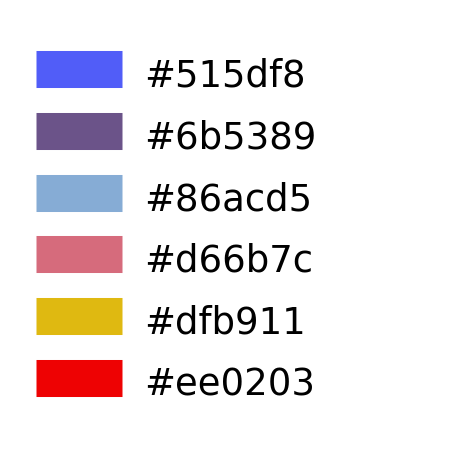

In [18]:
idx = np.where(tallies6 == np.sort(np.unique(tallies6))[-1])[0][0]
n = len(colors_rgb[6][0])

fig, ax = plt.subplots(figsize=(3, n * 0.5))

# Get height and width
w, Y = fig.get_dpi() * fig.get_size_inches()
h = Y / (n + 1)

for i, name in enumerate(colors_rgb[6][idx]):
    row = i
    y = Y - (row * h) - h
    xi_line = w * (0.05)
    xf_line = w * (0.25)
    xi_text = w * (0.3)
    ax.text(
        xi_text,
        y,
        "#" + name,
        fontsize=(h * 0.6),
        horizontalalignment="left",
        verticalalignment="center",
    )

    ax.hlines(y + h * 0.1, xi_line, xf_line, color="#" + name, linewidth=(h * 0.6))
ax.set_xlim(0, w)
ax.set_ylim(0, Y)
ax.set_axis_off()
fig.subplots_adjust(left=0, right=1, top=1, bottom=0, hspace=0, wspace=0)
plt.show()

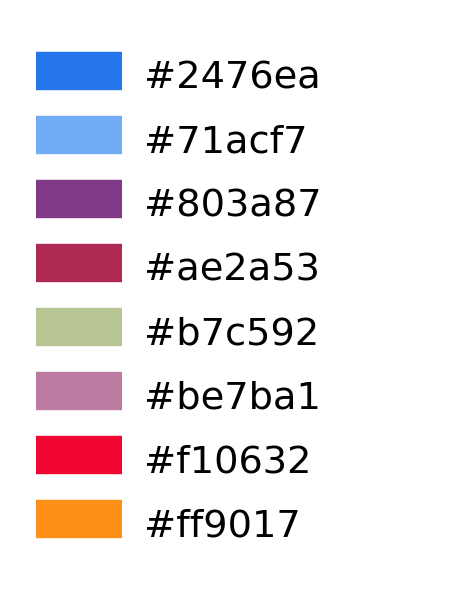

In [19]:
idx = np.where(tallies8 == np.sort(np.unique(tallies8))[-1])[0][0]
n = len(colors_rgb[8][0])

fig, ax = plt.subplots(figsize=(3, n * 0.5))

# Get height and width
w, Y = fig.get_dpi() * fig.get_size_inches()
h = Y / (n + 1)

for i, name in enumerate(colors_rgb[8][idx]):
    row = i
    y = Y - (row * h) - h
    xi_line = w * (0.05)
    xf_line = w * (0.25)
    xi_text = w * (0.3)
    ax.text(
        xi_text,
        y,
        "#" + name,
        fontsize=(h * 0.6),
        horizontalalignment="left",
        verticalalignment="center",
    )

    ax.hlines(y + h * 0.1, xi_line, xf_line, color="#" + name, linewidth=(h * 0.6))
ax.set_xlim(0, w)
ax.set_ylim(0, Y)
ax.set_axis_off()
fig.subplots_adjust(left=0, right=1, top=1, bottom=0, hspace=0, wspace=0)
plt.show()

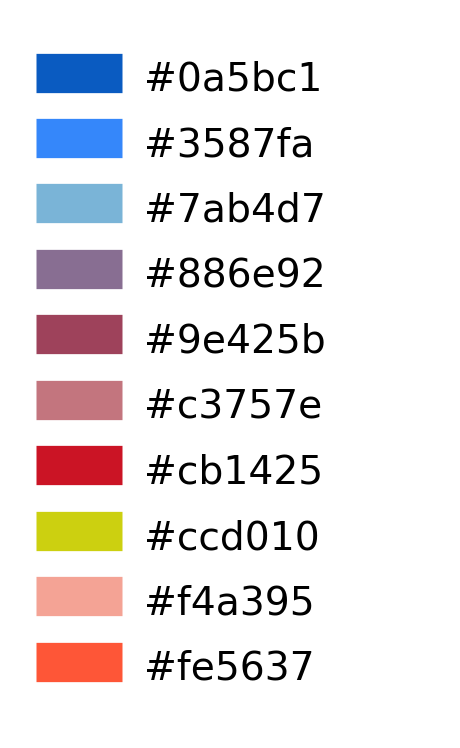

In [20]:
idx = np.where(tallies10 == np.sort(np.unique(tallies10))[-1])[0][0]
n = len(colors_rgb[10][0])

fig, ax = plt.subplots(figsize=(3, n * 0.5))

# Get height and width
w, Y = fig.get_dpi() * fig.get_size_inches()
h = Y / (n + 1)

for i, name in enumerate(colors_rgb[10][idx]):
    row = i
    y = Y - (row * h) - h
    xi_line = w * (0.05)
    xf_line = w * (0.25)
    xi_text = w * (0.3)
    ax.text(
        xi_text,
        y,
        "#" + name,
        fontsize=(h * 0.6),
        horizontalalignment="left",
        verticalalignment="center",
    )

    ax.hlines(y + h * 0.1, xi_line, xf_line, color="#" + name, linewidth=(h * 0.6))
ax.set_xlim(0, w)
ax.set_ylim(0, Y)
ax.set_axis_off()
fig.subplots_adjust(left=0, right=1, top=1, bottom=0, hspace=0, wspace=0)
plt.show()

## Compare machine-learning scores to other values and combined with saliency score

In [21]:
top_sets = {}

In [22]:
npz = np.load("../color-name-model/colornamemodel.npz")
cmap = npz["cmap"]
model_saliencies = npz["saliencies"]

In [23]:
def saliency(colors):
    # L*a*b* binning is used with rounding function to match the Heer & Stone (2012)
    # supplementary Java code used to construct the naming model. Although L*a*b* is
    # traditionally used with a D50 white point, a D65 white point is used here to match
    # what Heer & Stone (2012) used (it's also the Colorspacious default). Colorspacious
    # and Heer & Stone (2012) use slightly different matrices for converting from linear
    # sRGB to XYZ, but this is not a significant issue.
    lab = colorspacious.cspace_convert(
        colors, "sRGB255", {"name": "CIELab", "XYZ100_w": "D65"}
    )
    return scipy.interpolate.griddata(
        cmap,
        model_saliencies,
        lab.reshape((lab.shape[0] * lab.shape[1], lab.shape[2])),
        method="linear",
    ).reshape(lab.shape[:2])

### Six colors

In [24]:
jab_tmp = colors_sorted_by_j[6].reshape((colors_sorted_by_j[6].shape[0], 6, 3))
rgb_tmp = np.array(
    [
        [(int(j[:2], 16), int(j[2:4], 16), int(j[4:], 16)) for j in i]
        for i in colors_rgb[6]
    ]
)
scores_tmp = scores[6].mean(axis=0)

poly([24.67993126  0.45088288])


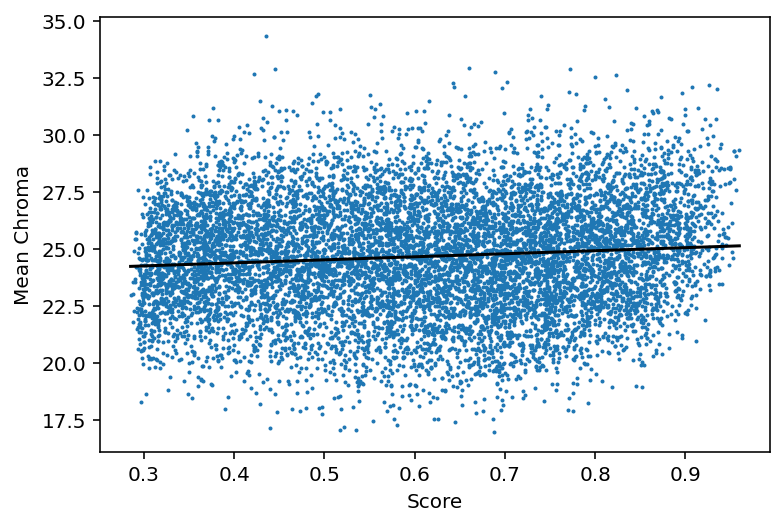

In [25]:
chroma = np.mean(np.sqrt(jab_tmp[:, :, 1] ** 2 + jab_tmp[:, :, 2] ** 2), axis=1)
linfit = np.polynomial.Polynomial.fit(scores_tmp, chroma, 1)
plt.scatter(scores_tmp, chroma, s=1)
plt.plot(
    [min(scores_tmp), max(scores_tmp)],
    [linfit(min(scores_tmp)), linfit(max(scores_tmp))],
    color="black",
)
plt.xlabel("Score")
plt.ylabel("Mean Chroma")
print(linfit)

poly([36.01353436  0.5720251 ])


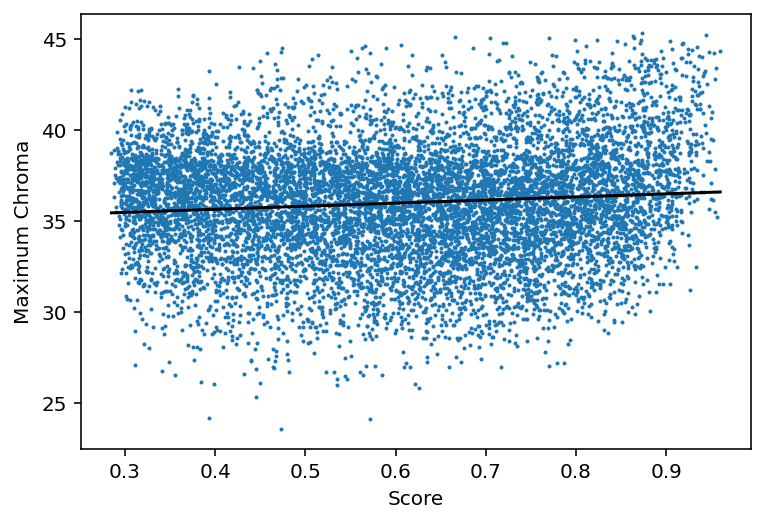

In [26]:
chroma = np.max(np.sqrt(jab_tmp[:, :, 1] ** 2 + jab_tmp[:, :, 2] ** 2), axis=1)
linfit = np.polynomial.Polynomial.fit(scores_tmp, chroma, 1)
plt.scatter(scores_tmp, chroma, s=1)
plt.plot(
    [min(scores_tmp), max(scores_tmp)],
    [linfit(min(scores_tmp)), linfit(max(scores_tmp))],
    color="black",
)
plt.xlabel("Score")
plt.ylabel("Maximum Chroma")
print(linfit)

poly([5.97934163e+01 3.29925272e-02])


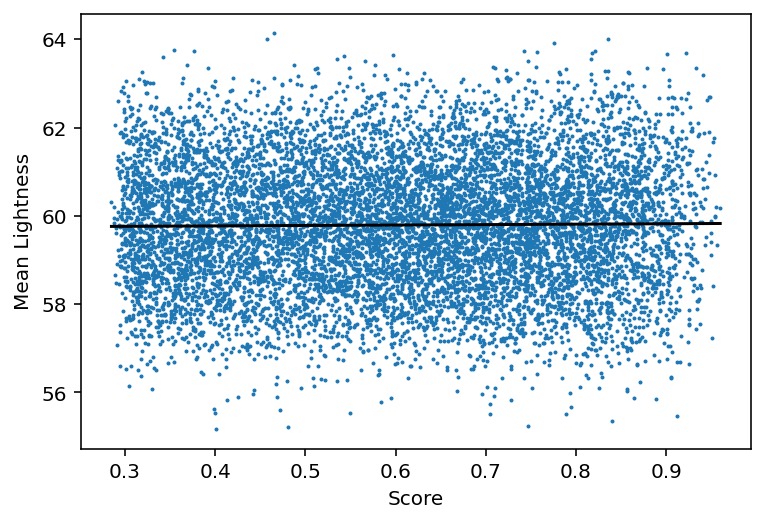

In [27]:
lightness = np.mean(jab_tmp[:, :, 0], axis=1)
linfit = np.polynomial.Polynomial.fit(scores_tmp, lightness, 1)
plt.scatter(scores_tmp, lightness, s=1)
plt.plot(
    [min(scores_tmp), max(scores_tmp)],
    [linfit(min(scores_tmp)), linfit(max(scores_tmp))],
    color="black",
)
plt.xlabel("Score")
plt.ylabel("Mean Lightness")
print(linfit)

poly([78.58039196 -0.24370932])


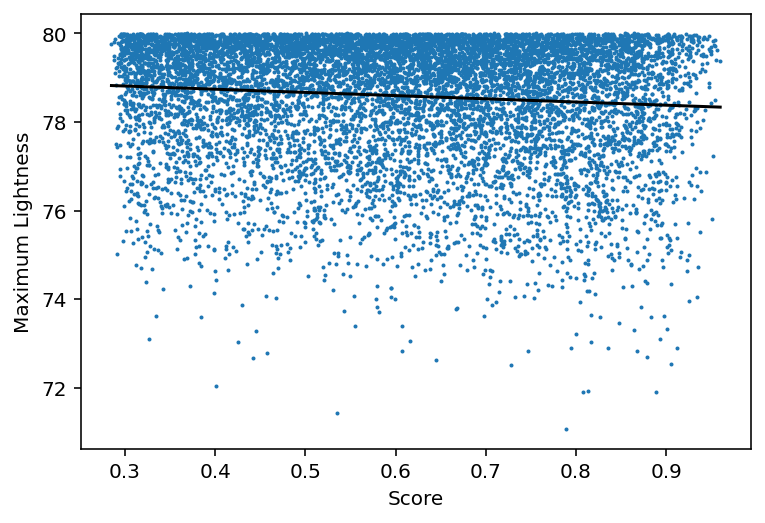

In [28]:
lightness = np.max(jab_tmp[:, :, 0], axis=1)
linfit = np.polynomial.Polynomial.fit(scores_tmp, lightness, 1)
plt.scatter(scores_tmp, lightness, s=1)
plt.plot(
    [min(scores_tmp), max(scores_tmp)],
    [linfit(min(scores_tmp)), linfit(max(scores_tmp))],
    color="black",
)
plt.xlabel("Score")
plt.ylabel("Maximum Lightness")
print(linfit)

poly([0.52143682 0.00656324])


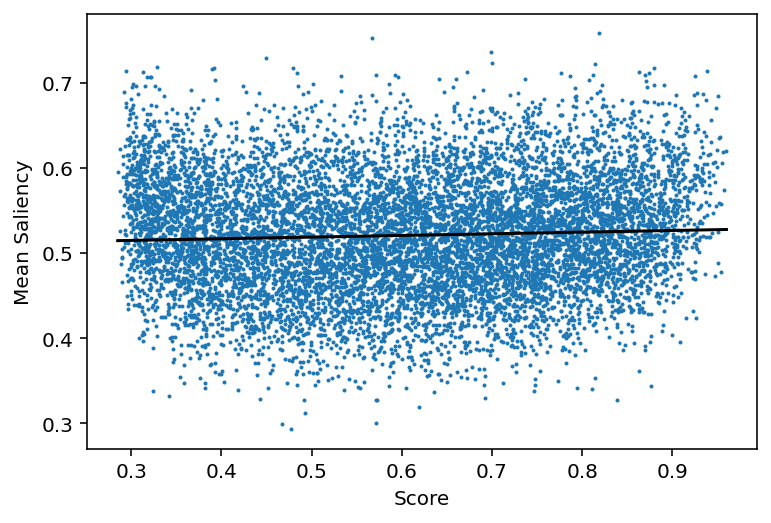

In [29]:
saliencies = np.mean(saliency(rgb_tmp), axis=1)
set_scores["saliency06"] = saliencies
linfit = np.polynomial.Polynomial.fit(scores_tmp, saliencies, 1)
plt.scatter(scores_tmp, saliencies, s=1)
plt.plot(
    [min(scores_tmp), max(scores_tmp)],
    [linfit(min(scores_tmp)), linfit(max(scores_tmp))],
    color="black",
)
plt.xlabel("Score")
plt.ylabel("Mean Saliency")
print(linfit)

7045


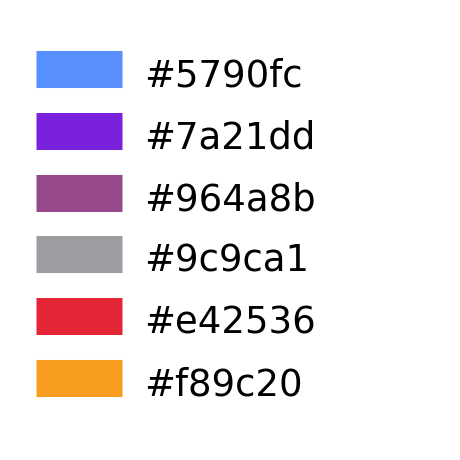

In [30]:
idx = np.argmax(scores_tmp * saliencies)
print(idx)
top_sets[6] = list(colors_rgb[6][idx])
n = len(colors_rgb[6][0])

fig, ax = plt.subplots(figsize=(3, n * 0.5))

# Get height and width
w, Y = fig.get_dpi() * fig.get_size_inches()
h = Y / (n + 1)

for i, name in enumerate(colors_rgb[6][idx]):
    row = i
    y = Y - (row * h) - h
    xi_line = w * (0.05)
    xf_line = w * (0.25)
    xi_text = w * (0.3)
    ax.text(
        xi_text,
        y,
        "#" + name,
        fontsize=(h * 0.6),
        horizontalalignment="left",
        verticalalignment="center",
    )

    ax.hlines(y + h * 0.1, xi_line, xf_line, color="#" + name, linewidth=(h * 0.6))
ax.set_xlim(0, w)
ax.set_ylim(0, Y)
ax.set_axis_off()
fig.subplots_adjust(left=0, right=1, top=1, bottom=0, hspace=0, wspace=0)
plt.show()

### Eight colors

In [31]:
jab_tmp = colors_sorted_by_j[8].reshape((colors_sorted_by_j[8].shape[0], 8, 3))
rgb_tmp = np.array(
    [
        [(int(j[:2], 16), int(j[2:4], 16), int(j[4:], 16)) for j in i]
        for i in colors_rgb[8]
    ]
)
scores_tmp = scores[8].mean(axis=0)

poly([24.57893633  0.43588141])


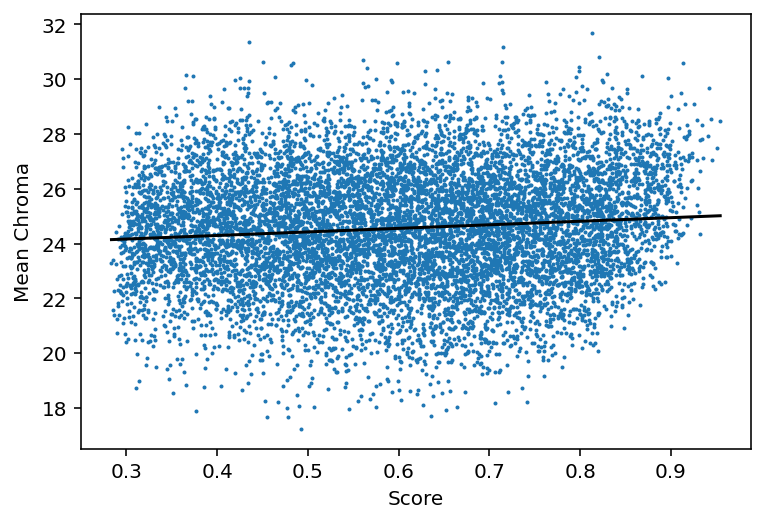

In [32]:
chroma = np.mean(np.sqrt(jab_tmp[:, :, 1] ** 2 + jab_tmp[:, :, 2] ** 2), axis=1)
linfit = np.polynomial.Polynomial.fit(scores_tmp, chroma, 1)
plt.scatter(scores_tmp, chroma, s=1)
plt.plot(
    [min(scores_tmp), max(scores_tmp)],
    [linfit(min(scores_tmp)), linfit(max(scores_tmp))],
    color="black",
)
plt.xlabel("Score")
plt.ylabel("Mean Chroma")
print(linfit)

poly([37.12713484  0.83966609])


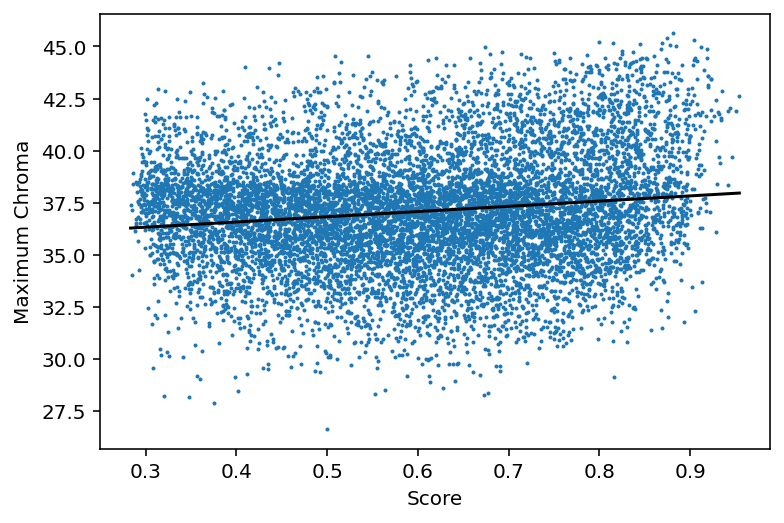

In [33]:
chroma = np.max(np.sqrt(jab_tmp[:, :, 1] ** 2 + jab_tmp[:, :, 2] ** 2), axis=1)
linfit = np.polynomial.Polynomial.fit(scores_tmp, chroma, 1)
plt.scatter(scores_tmp, chroma, s=1)
plt.plot(
    [min(scores_tmp), max(scores_tmp)],
    [linfit(min(scores_tmp)), linfit(max(scores_tmp))],
    color="black",
)
plt.xlabel("Score")
plt.ylabel("Maximum Chroma")
print(linfit)

poly([6.06891970e+01 4.81372487e-03])


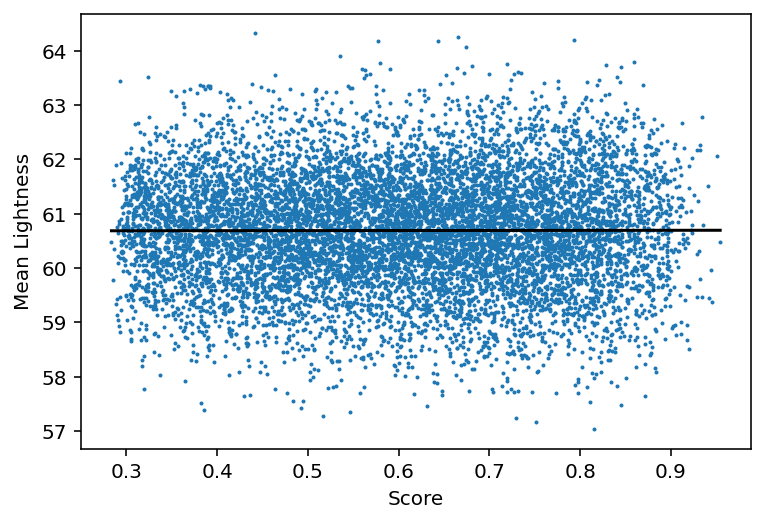

In [34]:
lightness = np.mean(jab_tmp[:, :, 0], axis=1)
linfit = np.polynomial.Polynomial.fit(scores_tmp, lightness, 1)
plt.scatter(scores_tmp, lightness, s=1)
plt.plot(
    [min(scores_tmp), max(scores_tmp)],
    [linfit(min(scores_tmp)), linfit(max(scores_tmp))],
    color="black",
)
plt.xlabel("Score")
plt.ylabel("Mean Lightness")
print(linfit)

poly([81.14886997 -0.08987285])


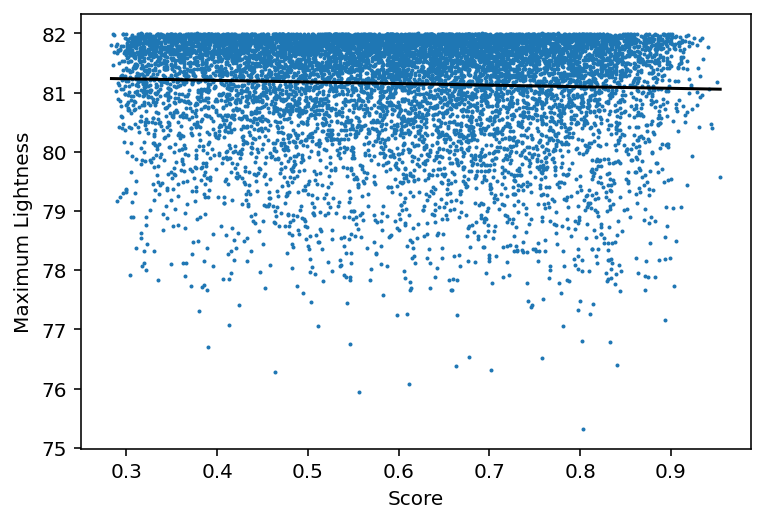

In [35]:
lightness = np.max(jab_tmp[:, :, 0], axis=1)
linfit = np.polynomial.Polynomial.fit(scores_tmp, lightness, 1)
plt.scatter(scores_tmp, lightness, s=1)
plt.plot(
    [min(scores_tmp), max(scores_tmp)],
    [linfit(min(scores_tmp)), linfit(max(scores_tmp))],
    color="black",
)
plt.xlabel("Score")
plt.ylabel("Maximum Lightness")
print(linfit)

poly([0.5150612  0.00830155])


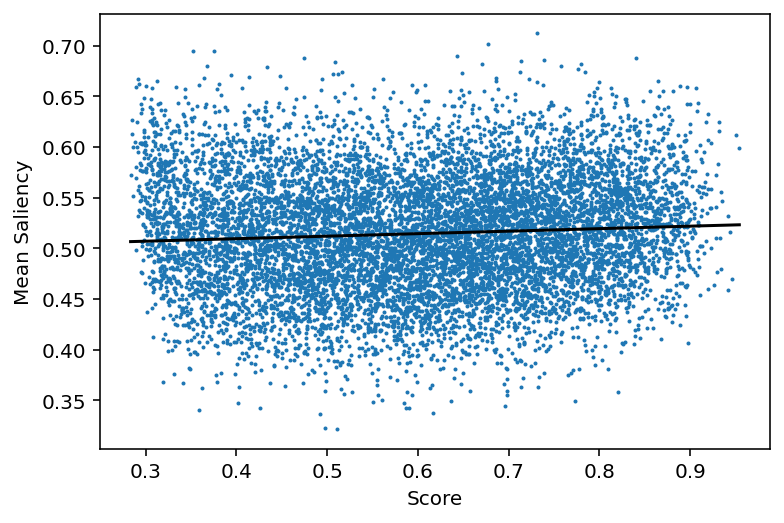

In [36]:
saliencies = np.mean(saliency(rgb_tmp), axis=1)
set_scores["saliency08"] = saliencies
linfit = np.polynomial.Polynomial.fit(scores_tmp, saliencies, 1)
plt.scatter(scores_tmp, saliencies, s=1)
plt.plot(
    [min(scores_tmp), max(scores_tmp)],
    [linfit(min(scores_tmp)), linfit(max(scores_tmp))],
    color="black",
)
plt.xlabel("Score")
plt.ylabel("Mean Saliency")
print(linfit)

1163


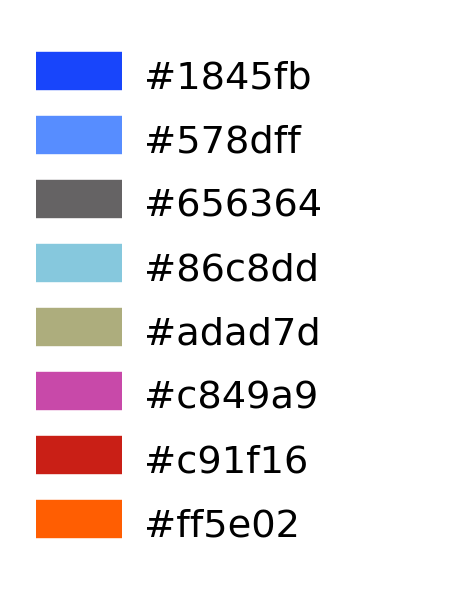

In [37]:
idx = np.argmax(scores_tmp * saliencies)
print(idx)
top_sets[8] = list(colors_rgb[8][idx])
n = len(colors_rgb[8][0])

fig, ax = plt.subplots(figsize=(3, n * 0.5))

# Get height and width
w, Y = fig.get_dpi() * fig.get_size_inches()
h = Y / (n + 1)

for i, name in enumerate(colors_rgb[8][idx]):
    row = i
    y = Y - (row * h) - h
    xi_line = w * (0.05)
    xf_line = w * (0.25)
    xi_text = w * (0.3)
    ax.text(
        xi_text,
        y,
        "#" + name,
        fontsize=(h * 0.6),
        horizontalalignment="left",
        verticalalignment="center",
    )

    ax.hlines(y + h * 0.1, xi_line, xf_line, color="#" + name, linewidth=(h * 0.6))
ax.set_xlim(0, w)
ax.set_ylim(0, Y)
ax.set_axis_off()
fig.subplots_adjust(left=0, right=1, top=1, bottom=0, hspace=0, wspace=0)
plt.show()

### Ten colors

In [38]:
jab_tmp = colors_sorted_by_j[10].reshape((colors_sorted_by_j[10].shape[0], 10, 3))
rgb_tmp = np.array(
    [
        [(int(j[:2], 16), int(j[2:4], 16), int(j[4:], 16)) for j in i]
        for i in colors_rgb[10]
    ]
)
scores_tmp = scores[10].mean(axis=0)

poly([24.22900967  0.62924506])


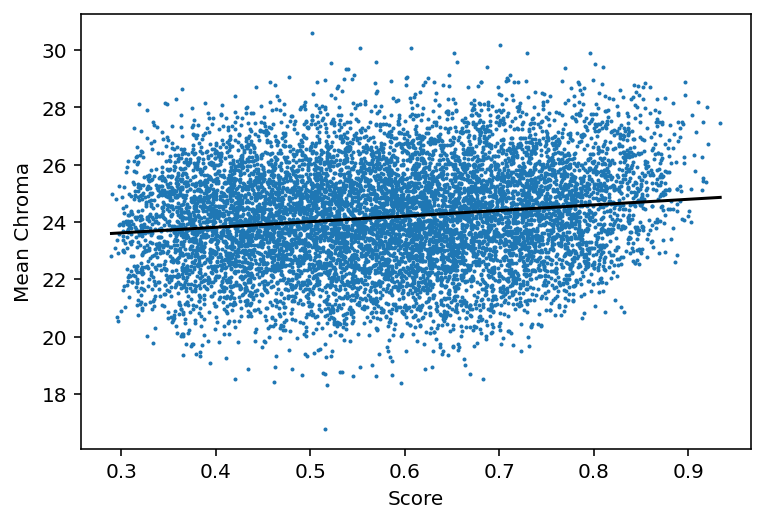

In [39]:
chroma = np.mean(np.sqrt(jab_tmp[:, :, 1] ** 2 + jab_tmp[:, :, 2] ** 2), axis=1)
linfit = np.polynomial.Polynomial.fit(scores_tmp, chroma, 1)
plt.scatter(scores_tmp, chroma, s=1)
plt.plot(
    [min(scores_tmp), max(scores_tmp)],
    [linfit(min(scores_tmp)), linfit(max(scores_tmp))],
    color="black",
)
plt.xlabel("Score")
plt.ylabel("Mean Chroma")
print(linfit)

poly([37.54939058  1.25599973])


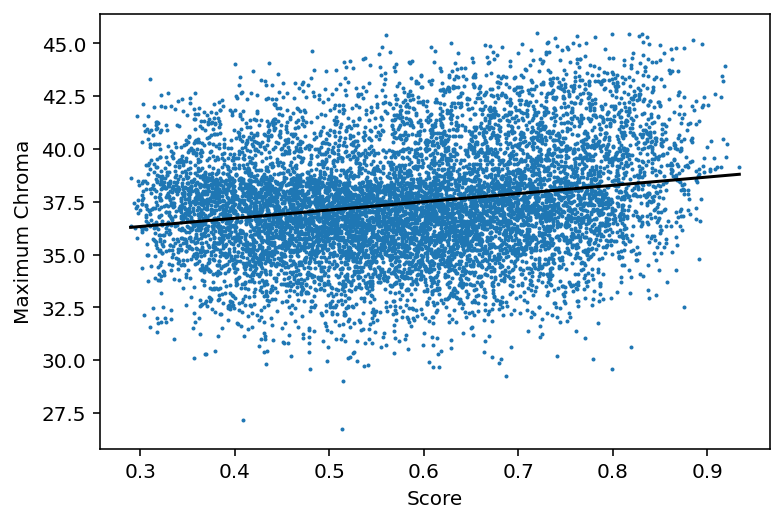

In [40]:
chroma = np.max(np.sqrt(jab_tmp[:, :, 1] ** 2 + jab_tmp[:, :, 2] ** 2), axis=1)
linfit = np.polynomial.Polynomial.fit(scores_tmp, chroma, 1)
plt.scatter(scores_tmp, chroma, s=1)
plt.plot(
    [min(scores_tmp), max(scores_tmp)],
    [linfit(min(scores_tmp)), linfit(max(scores_tmp))],
    color="black",
)
plt.xlabel("Score")
plt.ylabel("Maximum Chroma")
print(linfit)

poly([6.16484901e+01 2.65726987e-02])


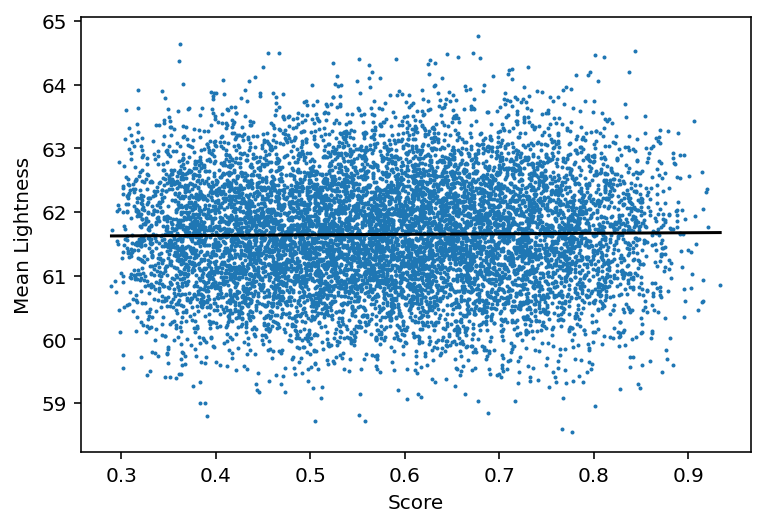

In [41]:
lightness = np.mean(jab_tmp[:, :, 0], axis=1)
linfit = np.polynomial.Polynomial.fit(scores_tmp, lightness, 1)
plt.scatter(scores_tmp, lightness, s=1)
plt.plot(
    [min(scores_tmp), max(scores_tmp)],
    [linfit(min(scores_tmp)), linfit(max(scores_tmp))],
    color="black",
)
plt.xlabel("Score")
plt.ylabel("Mean Lightness")
print(linfit)

poly([ 8.33079947e+01 -7.24018376e-02])


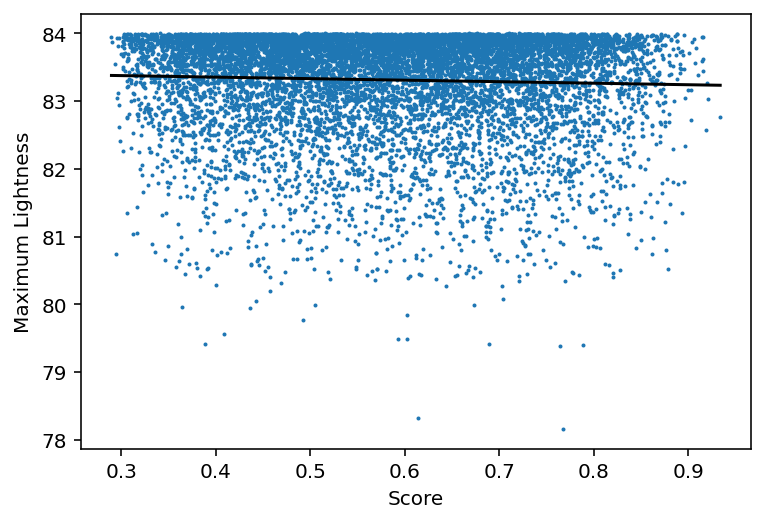

In [42]:
lightness = np.max(jab_tmp[:, :, 0], axis=1)
linfit = np.polynomial.Polynomial.fit(scores_tmp, lightness, 1)
plt.scatter(scores_tmp, lightness, s=1)
plt.plot(
    [min(scores_tmp), max(scores_tmp)],
    [linfit(min(scores_tmp)), linfit(max(scores_tmp))],
    color="black",
)
plt.xlabel("Score")
plt.ylabel("Maximum Lightness")
print(linfit)

poly([0.51018957 0.01076316])


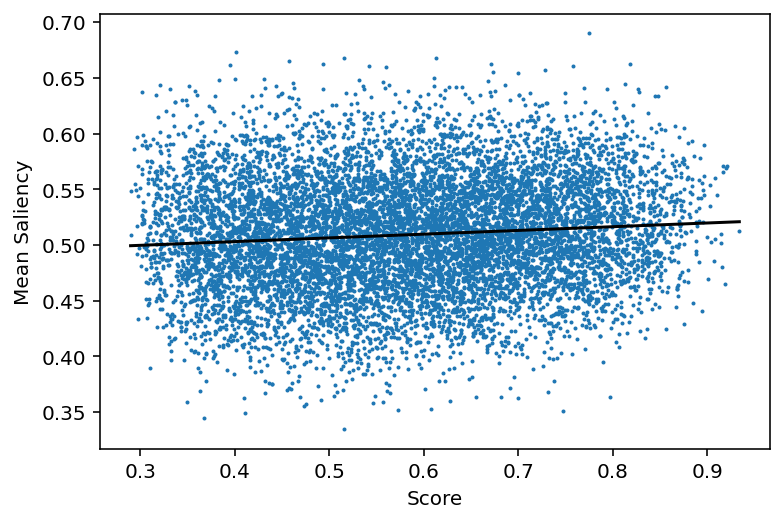

In [43]:
saliencies = np.mean(saliency(rgb_tmp), axis=1)
set_scores["saliency10"] = saliencies
linfit = np.polynomial.Polynomial.fit(scores_tmp, saliencies, 1)
plt.scatter(scores_tmp, saliencies, s=1)
plt.plot(
    [min(scores_tmp), max(scores_tmp)],
    [linfit(min(scores_tmp)), linfit(max(scores_tmp))],
    color="black",
)
plt.xlabel("Score")
plt.ylabel("Mean Saliency")
print(linfit)

5346


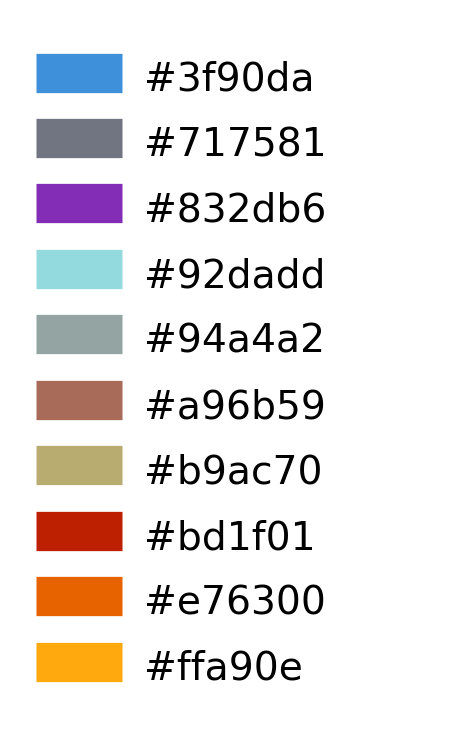

In [44]:
idx = np.argmax(scores_tmp * saliencies)
print(idx)
top_sets[10] = list(colors_rgb[10][idx])
n = len(colors_rgb[10][0])

fig, ax = plt.subplots(figsize=(3, n * 0.5))

# Get height and width
w, Y = fig.get_dpi() * fig.get_size_inches()
h = Y / (n + 1)

for i, name in enumerate(colors_rgb[10][idx]):
    row = i
    y = Y - (row * h) - h
    xi_line = w * (0.05)
    xf_line = w * (0.25)
    xi_text = w * (0.3)
    ax.text(
        xi_text,
        y,
        "#" + name,
        fontsize=(h * 0.6),
        horizontalalignment="left",
        verticalalignment="center",
    )

    ax.hlines(y + h * 0.1, xi_line, xf_line, color="#" + name, linewidth=(h * 0.6))
ax.set_xlim(0, w)
ax.set_ylim(0, Y)
ax.set_axis_off()
fig.subplots_adjust(left=0, right=1, top=1, bottom=0, hspace=0, wspace=0)
plt.show()

### Save results

In [45]:
np.savez_compressed("set-scores.npz", **set_scores)
with open("top-sets.json", "w") as outfile:
    json.dump(top_sets, outfile)